In [36]:
import glob
import json
import os

from prettytable import PrettyTable
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATASET = "adult"

In [37]:
risan_pd = pd.DataFrame()
kp1_pd = pd.DataFrame()
dpabst_pd = pd.DataFrame()

if os.path.exists("risan.csv"):
    os.remove("risan.csv")
if os.path.exists("kp1.csv"):
    os.remove("kp1.csv")
if os.path.exists("dpabst.csv"):
    os.remove("dpabst.csv")

for file in glob.glob("results/*/*/*/*.json"):
    args = file.split("/")
    dataset = args[1]
    model = args[2]
    fairness_condition = args[3]
    cost_cov = args[4].split(".json")[0]

    record: dict[str, str | float] = {
        "dataset": dataset,
        "fairness_condition": fairness_condition,
    }
    if model != "dpabst":
        record["cost_0"] = cost_cov.split("_")[0]
        record["cost_1"] = cost_cov.split("_")[1]

    with open(file, "r") as f:
        data = json.load(f)
    for key in data:
        record[f"{key}"] = float(data[key][0])
        record[f"{key}_s"] = float(data[key][1])
    temp = pd.Series(record)
    temp = temp.to_frame().T

    if model == "risan":
        risan_pd = pd.concat([risan_pd, temp])
    elif model == "dpabst":
        dpabst_pd = pd.concat([dpabst_pd, temp])
    elif model == "kp1":
        kp1_pd = pd.concat([kp1_pd, temp])

for col in risan_pd.columns:
    if col == "dataset" or col == "fairness_condition":
        continue
    risan_pd[col] = round(risan_pd[col].astype(float), 2)

for col in kp1_pd.columns:
    if col == "dataset" or col == "fairness_condition":
        continue
    kp1_pd[col] = round(kp1_pd[col].astype(float), 2)

for col in dpabst_pd.columns:
    if col == "dataset" or col == "fairness_condition":
        continue
    dpabst_pd[col] = round(dpabst_pd[col].astype(float), 2)

risan_pd = risan_pd.sort_values(by="cov")
kp1_pd = kp1_pd.sort_values(by="cov")
dpabst_pd = dpabst_pd.sort_values(by="cov")

risan_pd.to_csv("risan.csv", index=False)
kp1_pd.to_csv("kp1.csv", index=False)
dpabst_pd.to_csv("dpabst.csv", index=False)

In [38]:
risan_pd = risan_pd.loc[(risan_pd["dataset"] == DATASET)]
kp1_pd = kp1_pd.loc[(kp1_pd["dataset"] == DATASET)]
dpabst_pd = dpabst_pd.loc[(dpabst_pd["dataset"] == DATASET)]

In [39]:
formatting = {
    "risan": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN",
        "alpha": 0.4,
    },
    "risan g0": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN group 0",
        "alpha": 0.4,
    },
    "risan g1": {
        "color": "black",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN group 1",
        "alpha": 0.4,
    },
    "eq risan": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN",
        "alpha": 0.4,
    },
    "eq risan g0": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN group 0",
        "alpha": 0.4,
    },
    "eq risan g1": {
        "color": "blue",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE RISAN group 1",
        "alpha": 0.4,
    },

    "kp1": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1",
        "alpha": 0.4,
    },
    "kp1 g0": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 group 0",
        "alpha": 0.4,
    },
    "kp1 g1": {
        "color": "red",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 group 1",
        "alpha": 0.4,
    },
    "eq kp1": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1",
        "alpha": 0.4,
    },
    "eq kp1 g0": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1 group 0",
        "alpha": 0.4,
    },
    "eq kp1 g1": {
        "color": "darkorange",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE KP1 group 1",
        "alpha": 0.4,
    },

    "dpabst": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "eq dpabst g0": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "eq dpabst g1": {
        "color": "green",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },
}

In [40]:
def plot_with_std(x_vals, y_vals, y_std, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    fill_kwargs = formatting.copy()
    del fill_kwargs["label"]
    del fill_kwargs["marker"]
    plt.plot(x_vals, y_vals, **plot_kwargs)
    plt.fill_between(x_vals, y_vals - y_std, y_vals + y_std, **fill_kwargs)

def plot_without_std(x_vals, y_vals, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    plt.plot(x_vals, y_vals, **plot_kwargs)

In [41]:
def plots(dataframes: dict[str, pd.DataFrame], metric: str, std: bool, groupwise: bool, diff: bool):
    for key in dataframes:
        if std:
            if groupwise: # Individual model plots
                if key == "dpabst":
                    continue
                plot_with_std(
                    dataframes[key]["cov"],
                    dataframes[key][f"{metric}_0"],
                    dataframes[key][f"{metric}_0_s"],
                    formatting[f"{key} g0"],
                )
                plot_with_std(
                    dataframes[key]["cov"],
                    dataframes[key][f"{metric}_1"],
                    dataframes[key][f"{metric}_1_s"],
                    formatting[f"{key} g1"],
                )
            else: # Accuracy plots
                if key == "eq dpabst":
                    continue
                plot_with_std(
                    dataframes[key]["cov"],
                    dataframes[key][f"{metric}"],
                    dataframes[key][f"{metric}_s"],
                    formatting[f"{key}"],
                )
        else: # Difference plots
            if diff:
                if key == "eq dpabst":
                    continue
                plot_without_std(
                    dataframes[key]["cov"],
                    abs(dataframes[key][f"{metric}_0"] - dataframes[key][f"{metric}_1"]),
                    formatting[f"{key}"],
                )

# Independence section

In [42]:
risan_pd_none = risan_pd.loc[(risan_pd["fairness_condition"] == "none")]
kp1_pd_none = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")]

risan_pd_fair = risan_pd.loc[(risan_pd["fairness_condition"] == "ind")]
kp1_pd_fair = kp1_pd.loc[(kp1_pd["fairness_condition"] == "ind")]
dpabst_pd_fair = dpabst_pd.loc[(dpabst_pd["fairness_condition"] == "ind")]

if (
    not isinstance(risan_pd_none, pd.DataFrame)
    or not isinstance(risan_pd_fair, pd.DataFrame)
    or not isinstance(kp1_pd_none, pd.DataFrame)
    or not isinstance(kp1_pd_fair, pd.DataFrame)
    or not isinstance(dpabst_pd_fair, pd.DataFrame)
):
    exit()

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd_none,
    "eq risan": risan_pd_fair,
    "kp1": kp1_pd_none,
    "eq kp1": kp1_pd_fair,
    "dpabst": dpabst_pd_fair,
    "eq dpabst": dpabst_pd_fair,
}

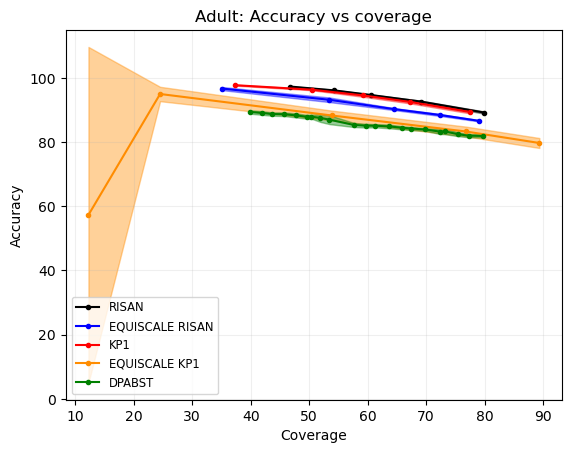

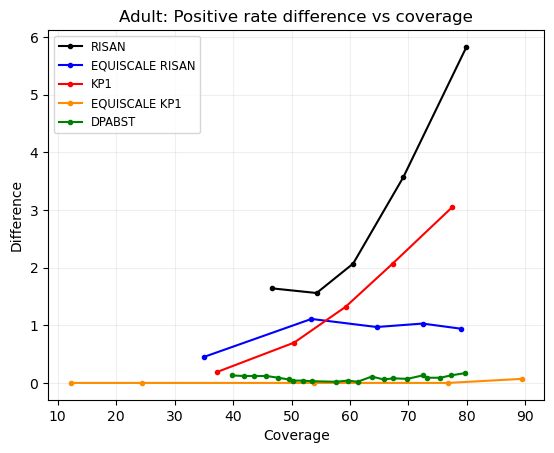

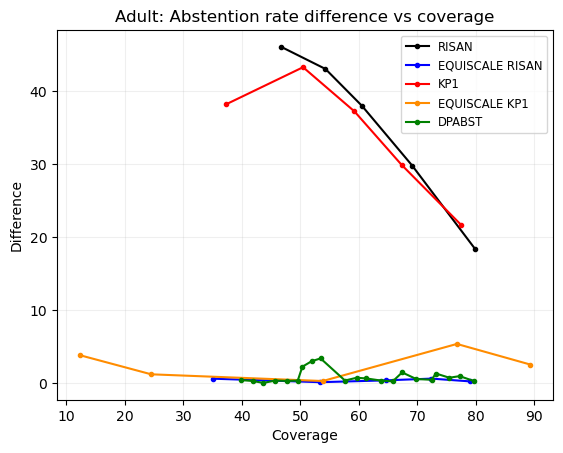

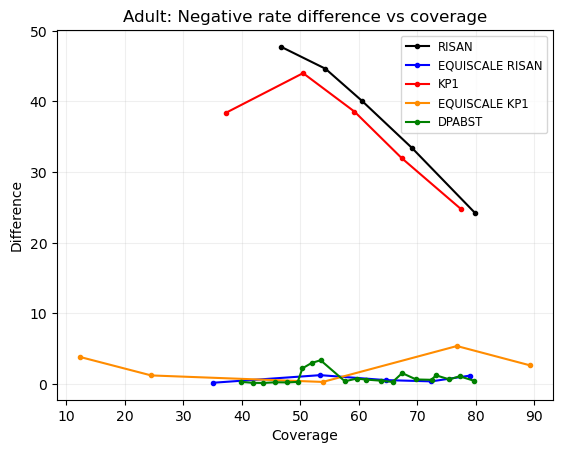

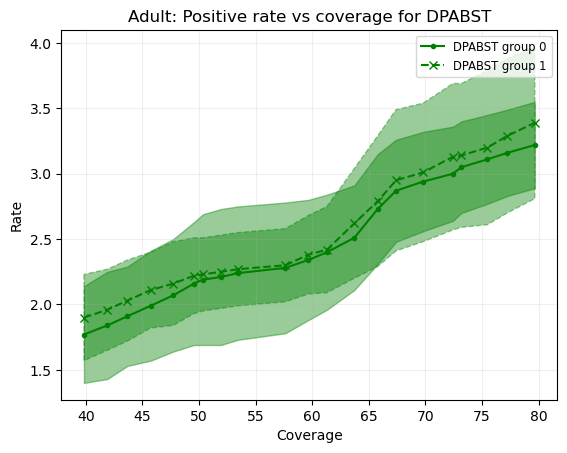

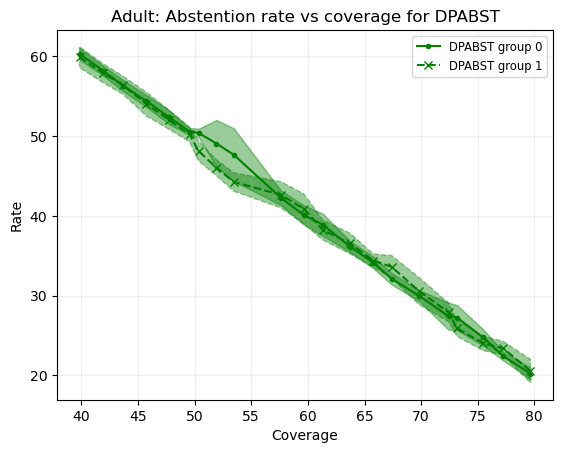

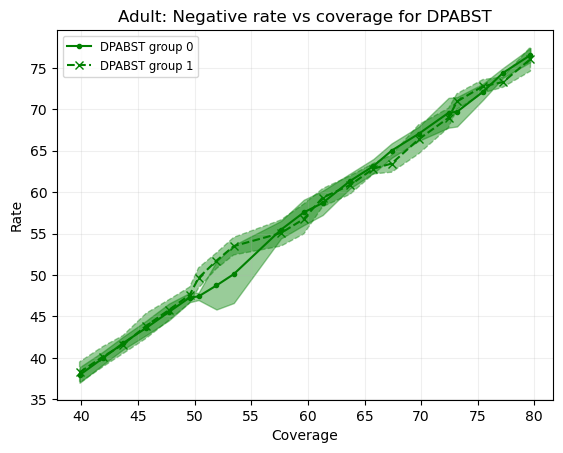

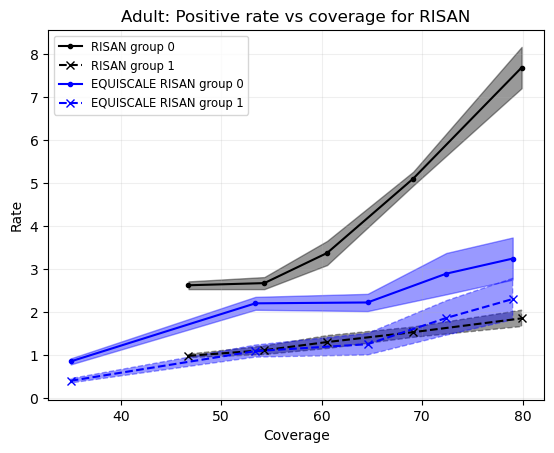

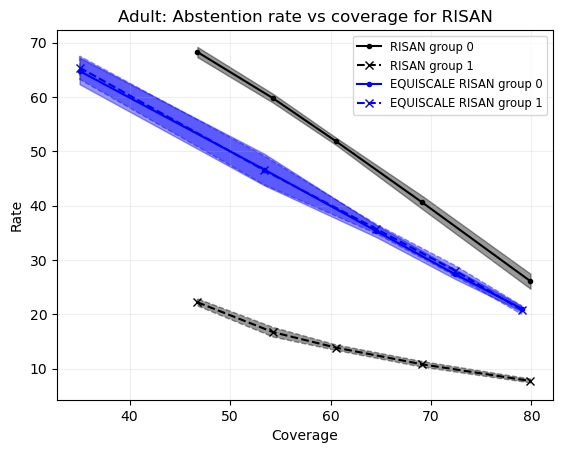

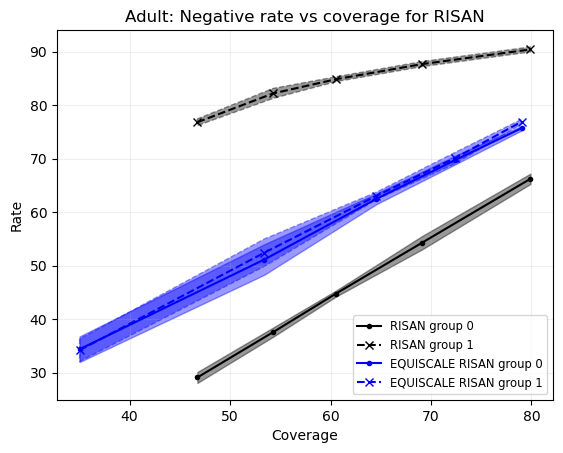

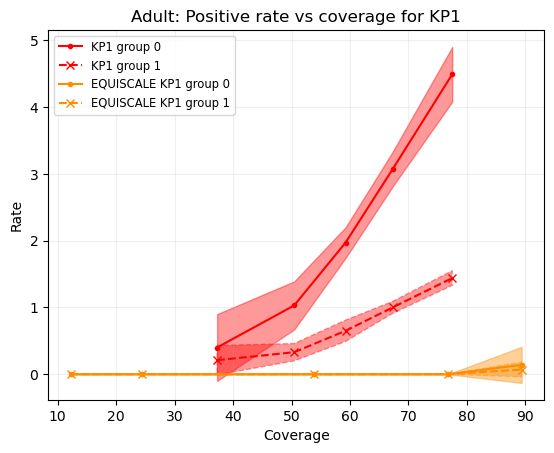

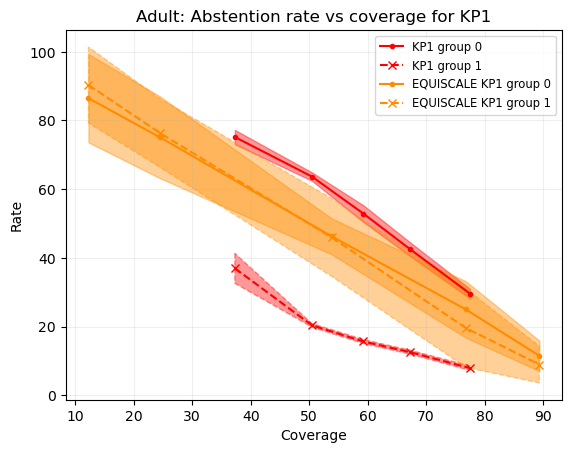

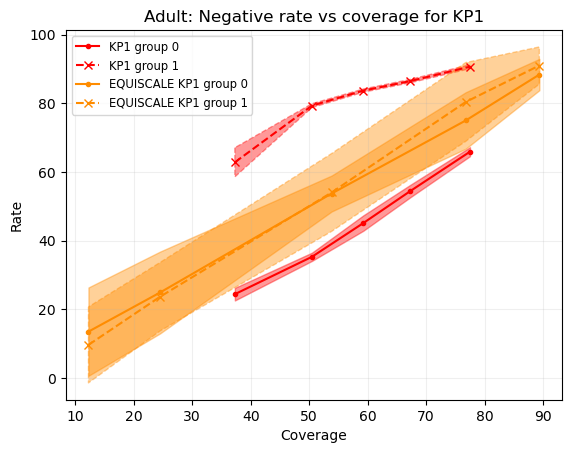

In [43]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "pos", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "abs", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "neg", False, False, True)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["eq dpabst"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["eq dpabst"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["eq dpabst"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


In [44]:

print("Average difference of rates")
table = PrettyTable(
    [
        "Model",
        "Positive",
        "Negative",
        "Abstention",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(np.average(
            np.abs((risan_pd_none["pos_0"] - risan_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((risan_pd_none["neg_0"] - risan_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((risan_pd_none["abs_0"] - risan_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(np.average(
            np.abs((risan_pd_fair["pos_0"] - risan_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((risan_pd_fair["neg_0"] - risan_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((risan_pd_fair["abs_0"] - risan_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(np.average(
            np.abs((kp1_pd_none["pos_0"] - kp1_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((kp1_pd_none["neg_0"] - kp1_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((kp1_pd_none["abs_0"] - kp1_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(np.average(
            np.abs((kp1_pd_fair["pos_0"] - kp1_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((kp1_pd_fair["neg_0"] - kp1_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((kp1_pd_fair["abs_0"] - kp1_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "DPABST",
        np.round(np.average(
            np.abs((dpabst_pd_fair["pos_0"] - dpabst_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((dpabst_pd_fair["neg_0"] - dpabst_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.average(
            np.abs((dpabst_pd_fair["abs_0"] - dpabst_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
print(table)

print("Standard deviation of the difference of rates")
table = PrettyTable(
    [
        "Model",
        "Positive",
        "Negative",
        "Abstention",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(np.std(
            np.abs((risan_pd_none["pos_0"] - risan_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((risan_pd_none["neg_0"] - risan_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((risan_pd_none["abs_0"] - risan_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(np.std(
            np.abs((risan_pd_fair["pos_0"] - risan_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((risan_pd_fair["neg_0"] - risan_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((risan_pd_fair["abs_0"] - risan_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(np.std(
            np.abs((kp1_pd_none["pos_0"] - kp1_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((kp1_pd_none["neg_0"] - kp1_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((kp1_pd_none["abs_0"] - kp1_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(np.std(
            np.abs((kp1_pd_fair["pos_0"] - kp1_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((kp1_pd_fair["neg_0"] - kp1_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((kp1_pd_fair["abs_0"] - kp1_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "DPABST",
        np.round(np.std(
            np.abs((dpabst_pd_fair["pos_0"] - dpabst_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((dpabst_pd_fair["neg_0"] - dpabst_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.std(
            np.abs((dpabst_pd_fair["abs_0"] - dpabst_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
print(table)

print("Max difference of rates")
table = PrettyTable(
    [
        "Model",
        "Positive",
        "Negative",
        "Abstention",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(np.max(
            np.abs((risan_pd_none["pos_0"] - risan_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((risan_pd_none["neg_0"] - risan_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((risan_pd_none["abs_0"] - risan_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(np.max(
            np.abs((risan_pd_fair["pos_0"] - risan_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((risan_pd_fair["neg_0"] - risan_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((risan_pd_fair["abs_0"] - risan_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(np.max(
            np.abs((kp1_pd_none["pos_0"] - kp1_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((kp1_pd_none["neg_0"] - kp1_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((kp1_pd_none["abs_0"] - kp1_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(np.max(
            np.abs((kp1_pd_fair["pos_0"] - kp1_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((kp1_pd_fair["neg_0"] - kp1_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((kp1_pd_fair["abs_0"] - kp1_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "DPABST",
        np.round(np.max(
            np.abs((dpabst_pd_fair["pos_0"] - dpabst_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((dpabst_pd_fair["neg_0"] - dpabst_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.max(
            np.abs((dpabst_pd_fair["abs_0"] - dpabst_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
print(table)

print("Min difference of rates")
table = PrettyTable(
    [
        "Model",
        "Positive",
        "Negative",
        "Abstention",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(np.min(
            np.abs((risan_pd_none["pos_0"] - risan_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((risan_pd_none["neg_0"] - risan_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((risan_pd_none["abs_0"] - risan_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(np.min(
            np.abs((risan_pd_fair["pos_0"] - risan_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((risan_pd_fair["neg_0"] - risan_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((risan_pd_fair["abs_0"] - risan_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(np.min(
            np.abs((kp1_pd_none["pos_0"] - kp1_pd_none["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((kp1_pd_none["neg_0"] - kp1_pd_none["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((kp1_pd_none["abs_0"] - kp1_pd_none["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(np.min(
            np.abs((kp1_pd_fair["pos_0"] - kp1_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((kp1_pd_fair["neg_0"] - kp1_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((kp1_pd_fair["abs_0"] - kp1_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
table.add_row(
    [
        "DPABST",
        np.round(np.min(
            np.abs((dpabst_pd_fair["pos_0"] - dpabst_pd_fair["pos_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((dpabst_pd_fair["neg_0"] - dpabst_pd_fair["neg_1"]).to_numpy())*100
        ), 4),
        np.round(np.min(
            np.abs((dpabst_pd_fair["abs_0"] - dpabst_pd_fair["abs_1"]).to_numpy())*100
        ), 4),
    ]
)
print(table)

Average difference of rates
+----------+----------+----------+------------+
|  Model   | Positive | Negative | Abstention |
+----------+----------+----------+------------+
|  RISAN   |  293.4   |  3800.0  |   3506.4   |
| EQ RISAN |   90.0   |   72.6   |    41.6    |
|   KP1    |  146.6   |  3555.0  |   3408.0   |
|  EQ KP1  |   1.4    |  268.6   |   267.0    |
|  DPABST  |  8.381   | 90.7143  |  90.3333   |
+----------+----------+----------+------------+
Standard deviation of the difference of rates
+----------+----------+----------+------------+
|  Model   | Positive | Negative | Abstention |
+----------+----------+----------+------------+
|  RISAN   | 161.8649 | 842.6223 | 1000.4314  |
| EQ RISAN | 23.2379  | 43.6971  |  19.5612   |
|   KP1    | 101.0952 | 659.9548 |  751.689   |
|  EQ KP1  |   2.8    | 181.4239 |  181.4927  |
|  DPABST  |  4.1802  | 89.1399  |  90.0938   |
+----------+----------+----------+------------+
Max difference of rates
+----------+----------+----------+----

# Separation section

In [45]:
risan_pd_none = risan_pd.loc[(risan_pd["fairness_condition"] == "none")]
kp1_pd_none = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")]

risan_pd_fair = risan_pd.loc[(risan_pd["fairness_condition"] == "sep")]
kp1_pd_fair = kp1_pd.loc[(kp1_pd["fairness_condition"] == "sep")]

risan_pd_none_cost = risan_pd.loc[(risan_pd["fairness_condition"] == "none")].sort_values(by="cost")
kp1_pd_none_cost = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")].sort_values(by="cost")

risan_pd_fair_cost = risan_pd.loc[(risan_pd["fairness_condition"] == "ind")].sort_values(by="cost")
kp1_pd_fair_cost = kp1_pd.loc[(kp1_pd["fairness_condition"] == "ind")].sort_values(by="cost")

KeyError: 'cost'

In [ ]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
metric = "acc"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[metric],
    risan_pd_none[f"{metric}_s"],
    formatting["risan"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[metric],
    risan_pd_fair[f"{metric}_s"],
    formatting["eq risan"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[metric],
    kp1_pd_none[f"{metric}_s"],
    formatting["kp1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[metric],
    kp1_pd_fair[f"{metric}_s"],
    formatting["eq kp1"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "tpr"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive Abstention rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "par"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "fpr"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "tnr"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative Abstention rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "nar"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "fnr"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tpr"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "par"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fpr"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tnr"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "nar"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fnr"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tpr"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "par"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fpr"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tnr"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "nar"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fnr"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


In [ ]:
print("Average difference of rates")
table = PrettyTable(
    [
        "Model",
        "TPR",
        "PAR",
        "FPR",
        "TNR",
        "NAR",
        "FNR",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(
            np.average(
                np.abs((risan_pd_none["tpr_0"] - risan_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_none["par_0"] - risan_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_none["fpr_0"] - risan_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_none["tnr_0"] - risan_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_none["nar_0"] - risan_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_none["fnr_0"] - risan_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(
            np.average(
                np.abs((risan_pd_fair["tpr_0"] - risan_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_fair["par_0"] - risan_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_fair["fpr_0"] - risan_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_fair["tnr_0"] - risan_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_fair["nar_0"] - risan_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((risan_pd_fair["fnr_0"] - risan_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(
            np.average(
                np.abs((kp1_pd_none["tpr_0"] - kp1_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_none["par_0"] - kp1_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_none["fpr_0"] - kp1_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_none["tnr_0"] - kp1_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_none["nar_0"] - kp1_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_none["fnr_0"] - kp1_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(
            np.average(
                np.abs((kp1_pd_fair["tpr_0"] - kp1_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_fair["par_0"] - kp1_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_fair["fpr_0"] - kp1_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_fair["tnr_0"] - kp1_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_fair["nar_0"] - kp1_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.average(
                np.abs((kp1_pd_fair["fnr_0"] - kp1_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
print(table)

print("Standard deviation of difference of rates")
table = PrettyTable(
    [
        "Model",
        "TPR",
        "PAR",
        "FPR",
        "TNR",
        "NAR",
        "FNR",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(
            np.std(
                np.abs((risan_pd_none["tpr_0"] - risan_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_none["par_0"] - risan_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_none["fpr_0"] - risan_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_none["tnr_0"] - risan_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_none["nar_0"] - risan_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_none["fnr_0"] - risan_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(
            np.std(
                np.abs((risan_pd_fair["tpr_0"] - risan_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_fair["par_0"] - risan_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_fair["fpr_0"] - risan_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_fair["tnr_0"] - risan_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_fair["nar_0"] - risan_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((risan_pd_fair["fnr_0"] - risan_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(
            np.std(
                np.abs((kp1_pd_none["tpr_0"] - kp1_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_none["par_0"] - kp1_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_none["fpr_0"] - kp1_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_none["tnr_0"] - kp1_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_none["nar_0"] - kp1_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_none["fnr_0"] - kp1_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(
            np.std(
                np.abs((kp1_pd_fair["tpr_0"] - kp1_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_fair["par_0"] - kp1_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_fair["fpr_0"] - kp1_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_fair["tnr_0"] - kp1_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_fair["nar_0"] - kp1_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.std(
                np.abs((kp1_pd_fair["fnr_0"] - kp1_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
print(table)


print("Max of difference of rates")
table = PrettyTable(
    [
        "Model",
        "TPR",
        "PAR",
        "FPR",
        "TNR",
        "NAR",
        "FNR",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(
            np.max(
                np.abs((risan_pd_none["tpr_0"] - risan_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_none["par_0"] - risan_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_none["fpr_0"] - risan_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_none["tnr_0"] - risan_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_none["nar_0"] - risan_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_none["fnr_0"] - risan_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(
            np.max(
                np.abs((risan_pd_fair["tpr_0"] - risan_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_fair["par_0"] - risan_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_fair["fpr_0"] - risan_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_fair["tnr_0"] - risan_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_fair["nar_0"] - risan_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((risan_pd_fair["fnr_0"] - risan_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(
            np.max(
                np.abs((kp1_pd_none["tpr_0"] - kp1_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_none["par_0"] - kp1_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_none["fpr_0"] - kp1_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_none["tnr_0"] - kp1_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_none["nar_0"] - kp1_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_none["fnr_0"] - kp1_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(
            np.max(
                np.abs((kp1_pd_fair["tpr_0"] - kp1_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_fair["par_0"] - kp1_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_fair["fpr_0"] - kp1_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_fair["tnr_0"] - kp1_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_fair["nar_0"] - kp1_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.max(
                np.abs((kp1_pd_fair["fnr_0"] - kp1_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
print(table)


print("Min of difference of rates")
table = PrettyTable(
    [
        "Model",
        "TPR",
        "PAR",
        "FPR",
        "TNR",
        "NAR",
        "FNR",
    ]
)
table.add_row(
    [
        "RISAN",
        np.round(
            np.min(
                np.abs((risan_pd_none["tpr_0"] - risan_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_none["par_0"] - risan_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_none["fpr_0"] - risan_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_none["tnr_0"] - risan_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_none["nar_0"] - risan_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_none["fnr_0"] - risan_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ RISAN",
        np.round(
            np.min(
                np.abs((risan_pd_fair["tpr_0"] - risan_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_fair["par_0"] - risan_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_fair["fpr_0"] - risan_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_fair["tnr_0"] - risan_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_fair["nar_0"] - risan_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((risan_pd_fair["fnr_0"] - risan_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "KP1",
        np.round(
            np.min(
                np.abs((kp1_pd_none["tpr_0"] - kp1_pd_none["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_none["par_0"] - kp1_pd_none["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_none["fpr_0"] - kp1_pd_none["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_none["tnr_0"] - kp1_pd_none["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_none["nar_0"] - kp1_pd_none["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_none["fnr_0"] - kp1_pd_none["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
table.add_row(
    [
        "EQ KP1",
        np.round(
            np.min(
                np.abs((kp1_pd_fair["tpr_0"] - kp1_pd_fair["tpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_fair["par_0"] - kp1_pd_fair["par_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_fair["fpr_0"] - kp1_pd_fair["fpr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_fair["tnr_0"] - kp1_pd_fair["tnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_fair["nar_0"] - kp1_pd_fair["nar_1"]).to_numpy())
                * 100
            ),
            4,
        ),
        np.round(
            np.min(
                np.abs((kp1_pd_fair["fnr_0"] - kp1_pd_fair["fnr_1"]).to_numpy())
                * 100
            ),
            4,
        ),
    ]
)
print(table)



# Mixed section

In [ ]:
risan_pd_none = risan_pd.loc[(risan_pd["fairness_condition"] == "none")]
kp1_pd_none = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")]

risan_pd_fair = risan_pd.loc[(risan_pd["fairness_condition"] == "mixed")]
kp1_pd_fair = kp1_pd.loc[(kp1_pd["fairness_condition"] == "mixed")]
dpabst_pd_fair = dpabst_pd.loc[(dpabst_pd["fairness_condition"] == "ind")]

risan_pd_none_cost = risan_pd.loc[(risan_pd["fairness_condition"] == "none")].sort_values(by="cost")
kp1_pd_none_cost = kp1_pd.loc[(kp1_pd["fairness_condition"] == "none")].sort_values(by="cost")

risan_pd_fair_cost = risan_pd.loc[(risan_pd["fairness_condition"] == "mixed")].sort_values(by="cost")
kp1_pd_fair_cost = kp1_pd.loc[(kp1_pd["fairness_condition"] == "mixed")].sort_values(by="cost")


In [ ]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
metric = "acc"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[metric],
    risan_pd_none[f"{metric}_s"],
    formatting["risan"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[metric],
    risan_pd_fair[f"{metric}_s"],
    formatting["eq risan"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[metric],
    kp1_pd_none[f"{metric}_s"],
    formatting["kp1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[metric],
    kp1_pd_fair[f"{metric}_s"],
    formatting["eq kp1"],
)
plot_with_std(
    dpabst_pd_fair["cov"],
    dpabst_pd_fair[metric],
    dpabst_pd_fair[f"{metric}_s"],
    formatting["dpabst"],
)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "pos"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plot_without_std(
    dpabst_pd_fair["cov"],
    abs(dpabst_pd_fair[f"{metric}_0"] - dpabst_pd_fair[f"{metric}_1"]),
    formatting["dpabst"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: True negative rate difference vs coverage"
)
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "tnr"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plot_without_std(
    dpabst_pd_fair["cov"],
    abs(dpabst_pd_fair[f"{metric}_0"] - dpabst_pd_fair[f"{metric}_1"]),
    formatting["dpabst"],
)
plt.legend(fontsize="small")
plt.show()


plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: False negative rate difference vs coverage"
)
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
metric = "fnr"
plot_without_std(
    risan_pd_none["cov"],
    abs(risan_pd_none[f"{metric}_0"] - risan_pd_none[f"{metric}_1"]),
    formatting["risan"],
)
plot_without_std(
    risan_pd_fair["cov"],
    abs(risan_pd_fair[f"{metric}_0"] - risan_pd_fair[f"{metric}_1"]),
    formatting["eq risan"],
)
plot_without_std(
    kp1_pd_none["cov"],
    abs(kp1_pd_none[f"{metric}_0"] - kp1_pd_none[f"{metric}_1"]),
    formatting["kp1"],
)
plot_without_std(
    kp1_pd_fair["cov"],
    abs(kp1_pd_fair[f"{metric}_0"] - kp1_pd_fair[f"{metric}_1"]),
    formatting["eq kp1"],
)
plot_without_std(
    dpabst_pd_fair["cov"],
    abs(dpabst_pd_fair[f"{metric}_0"] - dpabst_pd_fair[f"{metric}_1"]),
    formatting["dpabst"],
)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "pos"
plot_with_std(
    dpabst_pd_fair["cov"],
    dpabst_pd_fair[f"{metric}_0"],
    dpabst_pd_fair[f"{metric}_0_s"],
    formatting["eq dpabst g0"],
)
plot_with_std(
    dpabst_pd_fair["cov"],
    dpabst_pd_fair[f"{metric}_1"],
    dpabst_pd_fair[f"{metric}_1_s"],
    formatting["eq dpabst g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for DPABST"
)
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tnr"
plot_with_std(
    dpabst_pd_fair["cov"],
    dpabst_pd_fair[f"{metric}_0"],
    dpabst_pd_fair[f"{metric}_0_s"],
    formatting["eq dpabst g0"],
)
plot_with_std(
    dpabst_pd_fair["cov"],
    dpabst_pd_fair[f"{metric}_1"],
    dpabst_pd_fair[f"{metric}_1_s"],
    formatting["eq dpabst g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for DPABST"
)
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fnr"
plot_with_std(
    dpabst_pd_fair["cov"],
    dpabst_pd_fair[f"{metric}_0"],
    dpabst_pd_fair[f"{metric}_0_s"],
    formatting["eq dpabst g0"],
)
plot_with_std(
    dpabst_pd_fair["cov"],
    dpabst_pd_fair[f"{metric}_1"],
    dpabst_pd_fair[f"{metric}_1_s"],
    formatting["eq dpabst g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "pos"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for RISAN"
)
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tnr"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for RISAN"
)
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fnr"
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_0"],
    risan_pd_none[f"{metric}_0_s"],
    formatting["risan g0"],
)
plot_with_std(
    risan_pd_none["cov"],
    risan_pd_none[f"{metric}_1"],
    risan_pd_none[f"{metric}_1_s"],
    formatting["risan g1"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_0"],
    risan_pd_fair[f"{metric}_0_s"],
    formatting["eq risan g0"],
)
plot_with_std(
    risan_pd_fair["cov"],
    risan_pd_fair[f"{metric}_1"],
    risan_pd_fair[f"{metric}_1_s"],
    formatting["eq risan g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "pos"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tnr"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for KP1"
)
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fnr"
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_0"],
    kp1_pd_none[f"{metric}_0_s"],
    formatting["kp1 g0"],
)
plot_with_std(
    kp1_pd_none["cov"],
    kp1_pd_none[f"{metric}_1"],
    kp1_pd_none[f"{metric}_1_s"],
    formatting["kp1 g1"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_0"],
    kp1_pd_fair[f"{metric}_0_s"],
    formatting["eq kp1 g0"],
)
plot_with_std(
    kp1_pd_fair["cov"],
    kp1_pd_fair[f"{metric}_1"],
    kp1_pd_fair[f"{metric}_1_s"],
    formatting["eq kp1 g1"],
)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for FNNC")
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "pos"
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for FNNC"
)
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "tnr"
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()

plt.title(
    f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for FNNC"
)
plt.xlabel("Coverage")
plt.ylabel("Rate")
metric = "fnr"
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.show()